# Statistical analysis

Increasing research has found the association between microbial dysbiosis and CRC. Basing on that, we will check for differences in microbial composition of control and CRC cases. We will also investigate statistical significance of differences if found any.

In [1]:
#| echo: false

import pandas as pd
import seaborn as sns
import numpy as np

# loading tab-seperated data file using pandas and transposing it
data = pd.read_csv('Nine_CRC_cohorts_taxon_profiles.tsv',sep='\t',header=None).T

# setting the first row as column names and then removing it
data = data.rename(columns=data.loc[0]).drop(0, axis=0)

# accessing Zeller et al., 2014 dataset
zeller_db = data.loc[data['dataset_name'] == 'ZellerG_2014',:]

# fetching microbacterial organism information-related columns
bacteria_colnames = [col for col in data.columns if 'k__Bacteria' in col]

# metadata colnames
metadata_colnames = ['dataset_name', 'sampleID', 'subjectID', 'body_site', 'study_condition',
                     'disease', 'age', 'age_category', 'gender', 'country','ajcc','alcohol',
                     'antibiotics_current_use','curator','disease_subtype','ever_smoke','fobt',
                     'hba1c','hdl','ldl','location','BMI']

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# dataset containing only bacterial microoganism's relative abundace
microbiome = zeller_db[bacteria_colnames]

# converting data types
for col in microbiome:
    microbiome.loc[:,col] = pd.to_numeric(microbiome[col], errors='coerce')

# fetching names of columns with abundance exceeding .001
columns_to_fetch = microbiome.columns[microbiome.max(axis=0) > 0.001]

# filtered dataset
microbiome_filtered = microbiome[columns_to_fetch]

# log transformation
microbiome_log = microbiome_filtered.applymap(lambda x: np.log10(x+.000001))

## Association between host's characteristics and CRC
We will now investigate for statistical differences among target classes in terms of patient demographics. 

### Age, BMI, and CRC
We start by investigating statistical significance of differences between age of control and CRC casese. For this test, we use **Mann-Whitney** test to investigate statistical significance of differences. 

The below figures show that **there are statistical significant differences between `control` and `CRC` groups. 

:::{.callout-note}
# Age

We found **statistical differences in age** of control and CRC group.

:::

In [2]:
from skbio.diversity import alpha
from statannot import add_stat_annotation

# functions to process the data and prepare in a format supporting phyloseq analysis
def get_sample_table(df):
    df = df[metadata_colnames]
    df = df.set_index('subjectID')
    df.drop(['dataset_name','sampleID'],axis=1,inplace=True)
    return df


def get_otu_taxa_table(df):
    """
    This function returns otu table that contains relative abundance of species 
    where columns are species and rows are cases.
    
    Args:
        df (dataframe): Dataframe of realtive abundance and metadata
    """
    df = df[bacteria_colnames + ['subjectID']]
    df.columns = ["OTU_{}".format(str(ind)) for ind, col in enumerate(bacteria_colnames)] + ['subjectID']
    df.index = df['subjectID']
    taxa_table = get_taxa_table(bacteria_colnames)
    return df, taxa_table


def get_taxa_table(list_of_otus):
    """
    This function parse all present microbial species at different heirarchy levels, e.g., class, order, phylum.
    
    """
    otu = 0
    mapping = {}
    taxa_cols = ['kingdom','phylum','class','order','family','genus','species']
    df = pd.DataFrame(columns=taxa_cols)
    otu_mapping = {}
    otu_ids = []
    for ind, otu in enumerate(list_of_otus):
        tmp = {}
        for col in taxa_cols:
            tmp[col] = get_specific_label(otu, col)
        tmp_df = pd.DataFrame([tmp])
        df = pd.concat([df,tmp_df], ignore_index=[0])

        otu_id = "OTU_{}".format(str(ind))
        otu_mapping[otu] = otu_id
        otu_ids.append(otu)

    df['OTU'] = ['OTU_{}'.format(str(ind)) for ind in df.index]
    df = df.set_index('OTU')
    return df


def get_specific_label(l, t):
    """
    This function parse the taxonomic assignment lable and fetch the specified information (e.g., kingdom, family)

    Args:
        l (str): string of taxonomy
        t (str): string specifying the requested information (e.g., kingdom, family, genus, etc.)

    Returns:
        str: requested heirarichal info 
    """
    taxa_order = {'kingdom':0,'phylum':1,'class':2,'order':3,'family':4,'genus':5,'species':6}

    try:
        specific_label = l.split('|')[taxa_order[t]]

        return specific_label.strip().split('__')[1]
    except:
        return 'Unknown'

    
def get_otu_detail(taxa_table, otu_label, rank):
    return taxa_table[otu_label][rank]


def aggregate_by_taxonomy(otu_table, taxa_table, taxa_rank):
    """
    This function aggregates data based on specified 
    taxa rank (e.g., kingdom, class, order, phylum, genus, species).
    """
    unique_values = (taxa_table[taxa_rank].unique())

    # mapping for otus to unique value of chosen taxa rank
    taxa_to_otu = {}

    # prepare the mapping
    for unique_value in unique_values:
        tdf = taxa_table.loc[taxa_table[taxa_rank] == unique_value, :]
        otus = tdf.index.to_list()   
        taxa_to_otu[unique_value.strip()] = otus
    
    # create a dictionary for formulating expressions
    taxa_to_exp = {}

    for key in taxa_to_otu.keys():
        taxa_to_exp[key] = '{} = 0.000001'.format(key)
        for otu in taxa_to_otu[key]:
            taxa_to_exp[key] += ' + ' + otu
            otu_table[otu] = pd.to_numeric(otu_table[otu], errors='coerce')

    agg_df = otu_table
    
    for key, expr in taxa_to_exp.items():
        agg_df[key] = 0
        agg_df = agg_df.eval(expr, engine='python')
        
    agg_df = agg_df[list(unique_values)]
    
    return agg_df   


def extend_with_alpha(df, metadata_features):
    """
    This function extends the dataframe with alpha diversity measures.
    
    Args:
        df: dataframe
        
        metadata_features: list of metadata feature names
        
    Returns:
        dataframe: extended dataframe with alpha diversity features
    """
    diversity_measures = pd.DataFrame()

    alpha_diversity_metrics = [
        "chao1",
        "shannon",
        "simpson",
        "simpson_e",
        "fisher_alpha",
        "berger_parker"
    ]

    shannon_diversity = df.apply(lambda x: alpha.shannon(x), axis=1)
    chao1_diversity   = df.apply(lambda x: alpha.chao1(x), axis=1)
    simpson_diversity   = df.apply(lambda x: alpha.simpson(x), axis=1)
    simpson_e_diversity   = df.apply(lambda x: alpha.simpson_e(x), axis=1)
    fisher_diversity   = df.apply(lambda x: alpha.fisher_alpha(x), axis=1)
    berger_parker_diversity   = df.apply(lambda x: alpha.berger_parker_d(x), axis=1)

    diversity_measures['shannon'] = shannon_diversity
    diversity_measures['chao1'] = chao1_diversity
    diversity_measures['simpson'] = simpson_diversity
    diversity_measures['simpson_e'] = simpson_e_diversity
    diversity_measures['fisher_alpha'] = fisher_diversity
    diversity_measures['berger_parker'] = berger_parker_diversity
    
    X_alpha = diversity_measures.reset_index().drop(['subjectID'], axis=1)
    X_extended = pd.concat([metadata_features,X_alpha],axis=1)
    
    return X_extended

# convert data tables into otu and taxa table
otu_table, taxa_table = get_otu_taxa_table(zeller_db)

# aggregating data at higher levels
phylum_agg = aggregate_by_taxonomy(otu_table, taxa_table, 'phylum')
genus_agg = aggregate_by_taxonomy(otu_table, taxa_table, 'genus')
order_agg = aggregate_by_taxonomy(otu_table, taxa_table, 'order')

color_palette = {'control':'green',
                'adenoma':'orange',
                'CRC':'#c80000'}

order = ['control', 'adenoma', 'CRC']
x = 'study_condition'

pairs = [
    ('control','adenoma'),
    ('control','CRC'),
    ('adenoma','CRC'),
]

metadata = zeller_db[metadata_colnames]

# changing data type of age and BMI
metadata['age'] = pd.to_numeric(metadata.age, errors='coerce')
metadata['BMI'] = pd.to_numeric(metadata.BMI, errors='coerce')

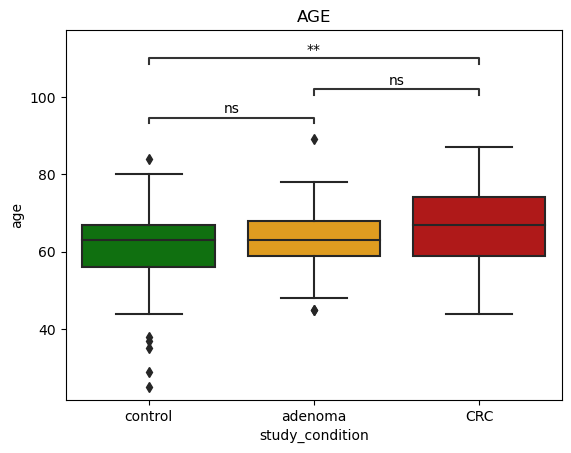

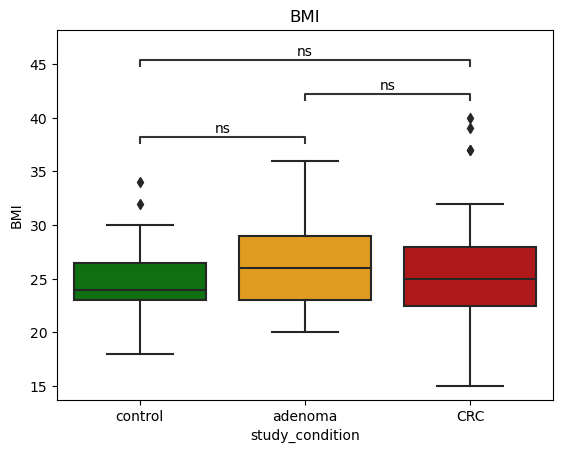

In [3]:
#| label: fig-stat-meta
#| fig-cap: "Age/BMI distribution"
#| fig-subcap: 
#|   - "Age"
#|   - "BMI"
#| layout-ncol: 2
# plotting distribution

for ind, y in enumerate(['age','BMI']):
    plt.figure()
    ax = sns.boxplot(data=metadata, y=y,x=x, palette=color_palette, order= order)
    #annot = Annotator(ax, pairs=pairs, data=metadata, x=x, y=y, hue=x, hue_order=order, order=order)
    ax, test_results = add_stat_annotation(ax, box_pairs=pairs, data=metadata, x=x, y=y,
                                           hue_order=order, order=order,
                                           test='Mann-Whitney', text_format='star',comparisons_correction=None, 
                                           loc='inside', verbose=False)

    plt.title(f'{y.upper()}')

    plt.show()
    


### Gender and CRC
We now check the distribution of gender across different target groups (i.e., control, adenoma, CRC). We employ the Chi-squared test to investigate the statistical significance of differences in gender distribution across different groups. 

@fig-stat-gender shows the frequency count of males/females across control, adenoma, and CRC groups. The differences were found to be statistically significant (p-value < .05).

:::{.callout-note}

# Gender

We also found statistical differences in gender between control, adenoma and CRC group.

:::

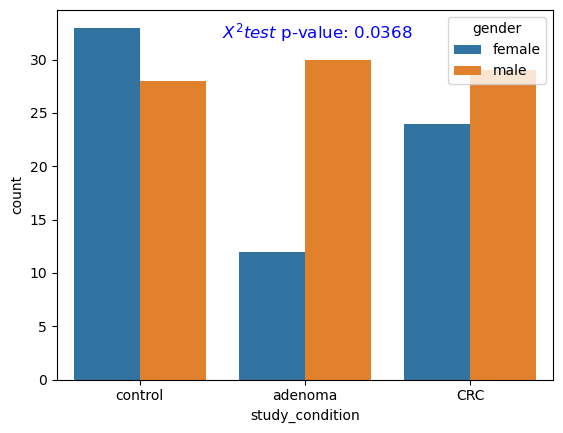

In [4]:
#| label: fig-stat-gender
#| fig-cap: "Gender distribution"

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(metadata['gender'], metadata['study_condition'])

# Apply Fisher's Exact Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# new figure
plt.figure()

# plot frequency plot
sns.countplot(data=metadata, x='study_condition',hue='gender')

# add p-value
plt.text(0.5, 32, f'$X^2 test$ p-value: {p_value:.4f}', fontsize=12, color='blue')
plt.show()

## Association between host's characteristics and species abundance

We will now explore for association between host's characteristics (e.g., age, BMI) and species relative abundace. @fig-stat-corr below shows correlation between host's characteristics and phylum level abundance data. 

* **Firnicutes, Spirochaetes, and Verrucomicrobia** phylum levels are negatively correlated with age. That means as a person gets older these three phylum levels tend to get decreased.

* In case of BMI, **Spirochaetes, Firnicutes, Deferribacteres, Bacteroidetes, and Actinobacteria** are found negatively correlated. That implies an increase in BMI (which could be taken as an indication of obesity) is associated with decrease in those phylums. 

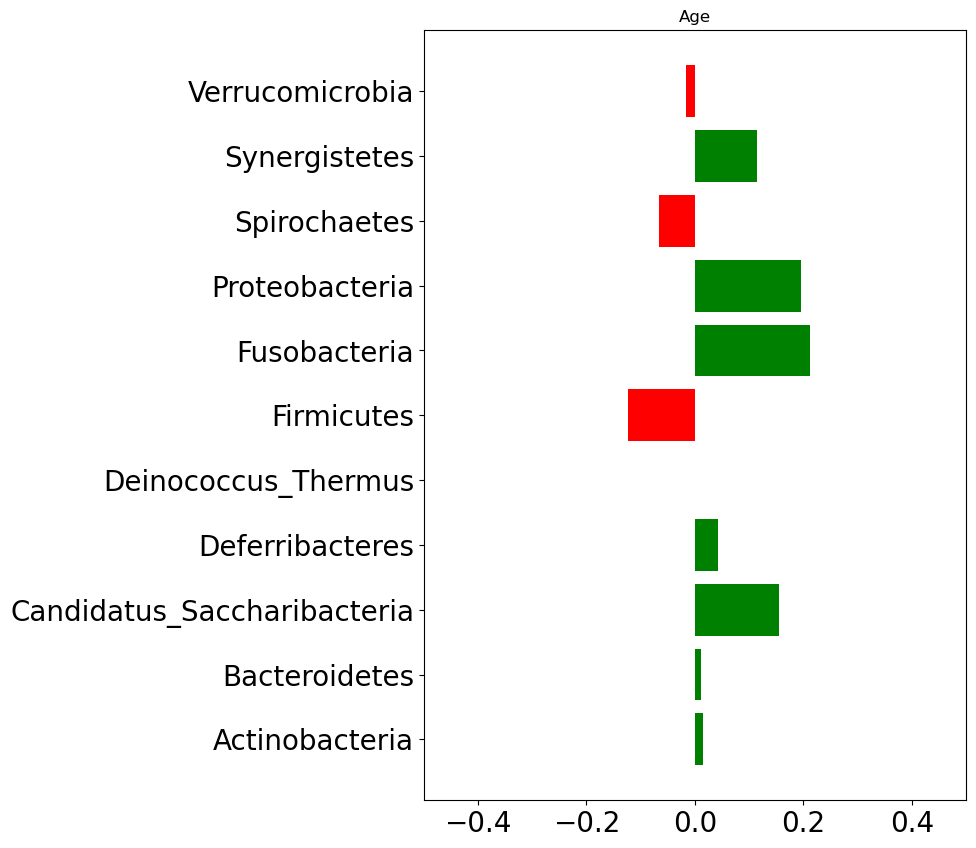

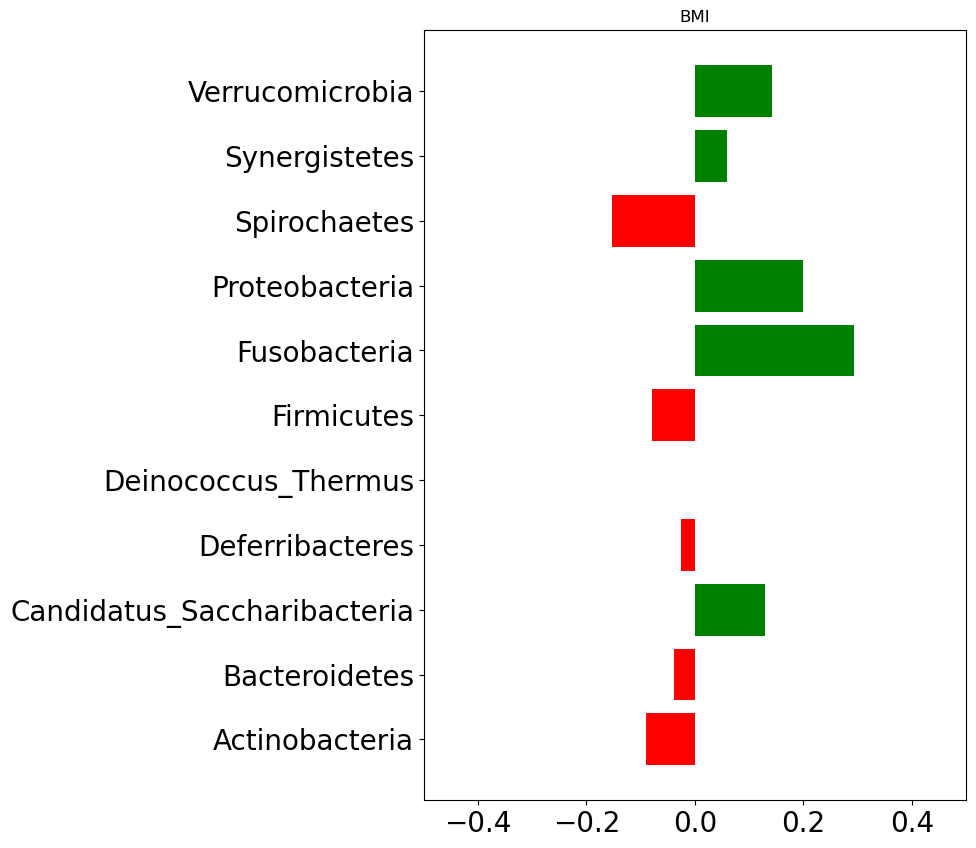

In [5]:
#| label: fig-stat-corr
#| fig-cap: "Correlation with phylum abundace"
#| fig-subcap: 
#|   - "Correlation between age and phylum level abundance"
#|   - "Correlation between BMI and phylum level abundance"
#|   - "CRC and phylum level abundance"
#| layout-ncol: 2
# plotting distribution

def extend_abundance_metadata(df,meta):
    """
    This function extends abundance data with metadata information.
    
    Args:
        df (DataFrame): relative abundance data
        meta (DataFrame): host's characteristics
        
    Returns:
        DataFrame
    """
    return pd.concat([df,meta],axis=1)

# relative abundance aggregation at 
#family_abundance = aggregate_by_taxonomy(otu_table, taxa_table, 'family')
genus_abundance = aggregate_by_taxonomy(otu_table, taxa_table, 'genus')
phylum_abundance = aggregate_by_taxonomy(otu_table, taxa_table, 'phylum')
metadata_ = metadata.set_index(metadata['subjectID'])

# plot age correlation plot
phylum_metadata = extend_abundance_metadata(phylum_abundance,metadata_[['age']])
phylum_corr = phylum_metadata.corr()
plt.figure(figsize=(7,10))
data_plot = phylum_corr['age'].drop('age')
bars = plt.barh(data_plot.index, data_plot, color=np.where(data_plot > 0, 'green', 'red'))
plt.xlim([-.5,.5])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Age')
plt.show()

# plot bmi correlation plot
phylum_metadata = extend_abundance_metadata(phylum_abundance,metadata_[['BMI']])
phylum_corr = phylum_metadata.corr()
plt.figure(figsize=(7,10))
data_plot = phylum_corr['BMI'].drop('BMI')
bars = plt.barh(data_plot.index, data_plot, color=np.where(data_plot > 0, 'green', 'red'))
plt.xlim([-.5,.5])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('BMI')
plt.show()
    
phylum_metadata_ = phylum_metadata.copy()
phylum_metadata_['study_condition'] = metadata_['study_condition'].apply(
    lambda x: 'malign' if x == 'CRC' else 'benign')

df = phylum_metadata_.melt(id_vars='study_condition',value_vars=phylum_agg.columns)


@fig-crc-phylum (c) below shows **differences in microbial composition in terms of phylum level abundance among `benign` and `malign` tumors**. We can notice three phylums differ among benign and malign tumor groups. Those phylums are **Proteobacteria**, **Firnicutes**, and **Bacteroidetes**.

> We combined control with adenoma to create `benign` tumor class, and CRC class renamed as `malign` tumor.


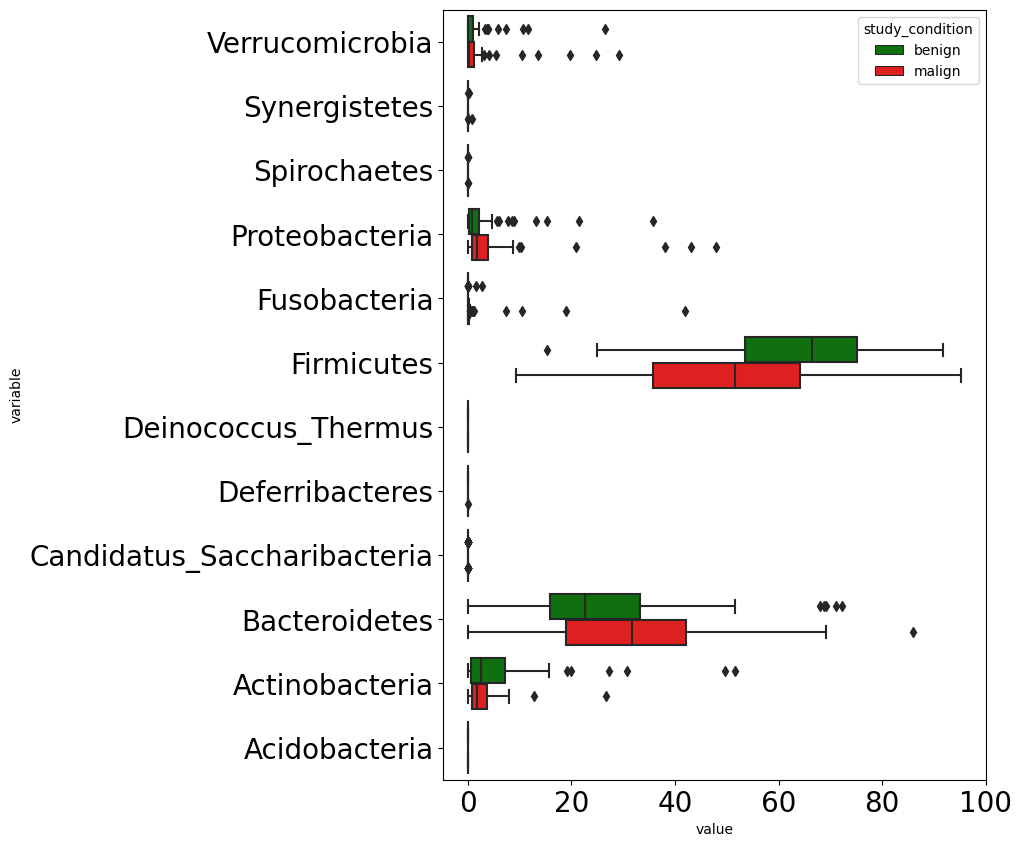

In [7]:
#| label: fig-crc-phylum
#| fig-cap: "CRC and phylum abundace"
plt.figure(figsize=(7,10))
sns.boxplot(data=df, y='variable',x='value', order=list(data_plot.index)[::-1], hue='study_condition', palette={'benign':'green','malign':'red'})
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

## Exploring Barteroidetes, Firmicutes, and Proteobacteria for theis association with CRc
We go further checking whether these differences are statistically significant or not. We employ `Mann-Whitney test` which is a non-parametric test for checking significance of differences in values from two independent groups. 

@fig-differ_phylum below shows distributions of abundance at phylum levels across `benign` and `malign` cases for all three selected phylumns. The differences were found to be **statistically significant**.

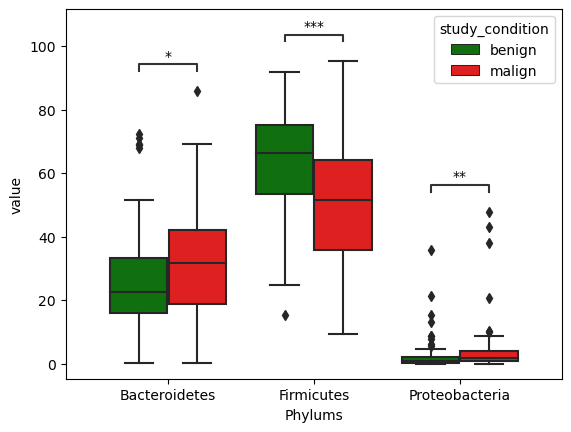

In [58]:
#| label: fig-differ_phylum
#| fig-cap: "Phylum differences among benign and malign cases"

color_palette = {'benign':'green','malign':'red'}

# selected phylums for statistical analysis
selected_phylums = ['Firmicutes','Proteobacteria','Bacteroidetes']

# extracting only selected phylum data
df_selected = df.loc[df['variable'].isin(selected_phylums),:]

# pairs for statistical test
pairs = [
    (('Firmicutes','benign'), ('Firmicutes','malign')),
    (('Proteobacteria','benign'), ('Proteobacteria','malign')),
    (('Bacteroidetes','benign'), ('Bacteroidetes','malign'))
]

# creating a new figure
plt.figure()

# plotting boxplot
ax = sns.boxplot(data=df_selected, x='variable', y='value',hue='study_condition', palette=color_palette)

# adding statistical annotation from Mann-Whitney test
ax, test_results = add_stat_annotation(ax, box_pairs=pairs, data=df_selected, x='variable', y='value', 
                                       hue='study_condition',hue_order=['benign','malign'], 
                                       
                                       test='Mann-Whitney', text_format='star',comparisons_correction=None, 
                                       loc='inside', verbose=False)

plt.xlabel('Phylums')

plt.show()

Lets go further and check which genus and species under these phylums are statistically different in terms of relative abundance among `benign` and `malign` tumors.

In [91]:
taxa_selected = taxa_table.loc[taxa_table['phylum'].isin(selected_phylums),:]

# fetching species related to selected phylums
selected_species_cols = list(taxa_table['species'].unique())

# fetching genus related to selected phylums
selected_genus_cols = list(taxa_table['genus'].unique())

# fetching family related to selected phylums
selected_family_cols = list(taxa_table['family'].unique())

# fetching order related to selected phylums
selected_order_cols = list(taxa_table['order'].unique())

# fetching order related to selected phylums
selected_class_cols = list(taxa_table['class'].unique())

In [148]:
from statannotations.Annotator import Annotator

def plot_selected_taxa(selected_taxa, plot_at,figsize=(7,15),log_scale=False,title=""):
    """
    Args:
    ----
        selected_taxa(str): taxa which are selected for further exploration
        taxa_abun_df (dataframe): relative abundance data at taxa
        plot_at (str): taxa at which distribution will be plotted for benign and malign tumors
    
    
    """
    df_abundance = aggregate_by_taxonomy(otu_table, taxa_table, plot_at)
    metadata_ = metadata.set_index(metadata['subjectID'])

    taxa_abundance_selected = df_abundance[selected_taxa]

    taxa_abundance_selected['study_condition'] = metadata_['study_condition'].apply(
    lambda x: 'malign' if x == 'CRC' else 'benign')

    
    pairs = []
    
    for col in taxa_abundance_selected.columns:
        if col != 'study_condition':
            pairs.append(((col,'benign'),(col,'malign')))

    plt.figure(figsize=figsize)
    plot_df = taxa_abundance_selected.melt(id_vars='study_condition',value_vars=selected_taxa)
    
    ax = sns.boxplot(data=plot_df,x='variable',y='value',hue='study_condition', palette=color_palette)
    add_stat_annotation(ax, box_pairs=pairs, data=plot_df, x='variable', y='value', 
                                       hue='study_condition',hue_order=['benign','malign'], 
                                       
                                       test='Mann-Whitney', text_format='star',comparisons_correction=None, 
                                       loc='inside', verbose=False)  
    ax.set_ylabel(plot_at)
    plt.xticks(rotation='vertical')
    if log_scale:
        ax.set_yscale('log')
    plt.title(title)
    plt.show()

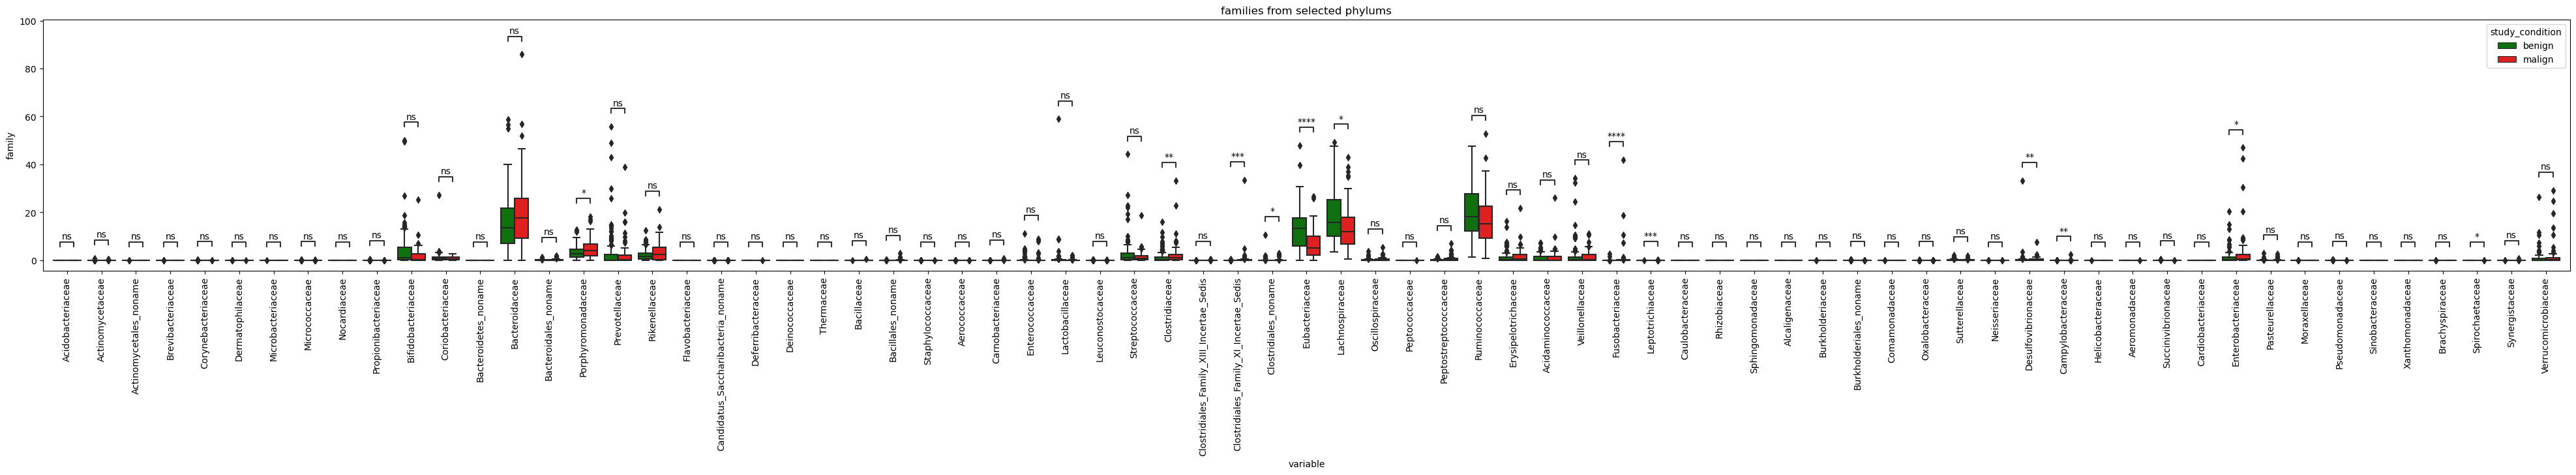

In [151]:
plot_selected_taxa(selected_family, plot_at='family', figsize=(50,5),title='families from selected phylums')


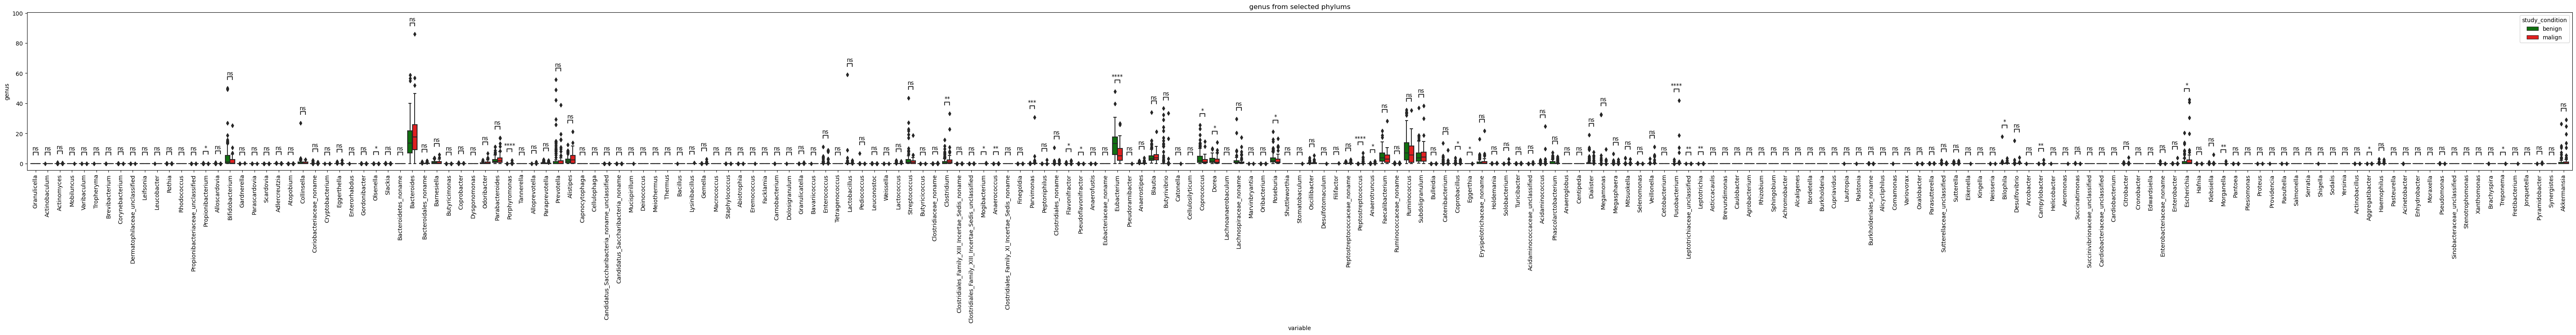

In [152]:
plot_selected_taxa(selected_genus, plot_at='genus', figsize=(80,5),title='genus from selected phylums')
